<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Model_development/Miraflores/modelDevelopment_zona2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias



Cargamos las librerías que utilizaremos en el proyecto

In [ ]:
import pandas as pd

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from sklearn.metrics import *

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# Data

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos de la zona 2

In [ ]:
pddf = pd.read_csv('datos_miraflores.csv', index_col=['codmes'], parse_dates=['codmes']).fillna(0)
pddf = pddf[['Oferta_zona_2', 'Venta_zona_2']]


In [ ]:

macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])
variables_macro = macro.columns.tolist()

macro[variables_macro] = macro[variables_macro].shift(3)
macro.head()


In [ ]:
asei = pd.read_csv('variables_asei_new.csv', delimiter = ';', index_col=['codmes'], parse_dates=['codmes'])
variables_asei = asei.columns.tolist()

asei[variables_asei] = asei[variables_asei].shift(2)
asei.head()

In [ ]:
pddf2 = pd.merge(pddf, macro, on = 'codmes', how='left').copy()
pddf2 = pd.merge(pddf2, asei, on = 'codmes', how='left')

variables = variables_macro + variables_asei + ['Oferta_zona_2']


In [ ]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]

In [ ]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

# Forecasting

Muestreamos la data en train y test bajo metodología OOT

In [ ]:
pddfTS = pddf[['Venta_zona_2']].copy()

X_train = pddfTS[:-4]
X_test  = pddfTS[-4:]


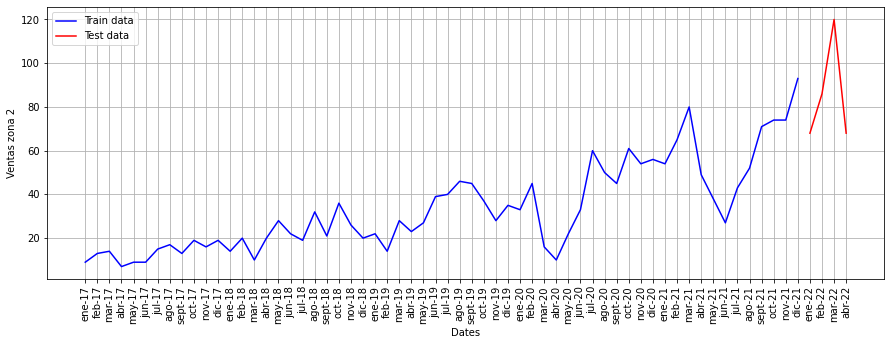

In [ ]:
#split data into train and training set
plt.figure(figsize=(15,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Ventas zona 2')
plt.plot(X_train, 'blue', label='Train data')
plt.plot(X_test, 'red', label='Test data')
plt.xticks(rotation=90)
plt.legend()

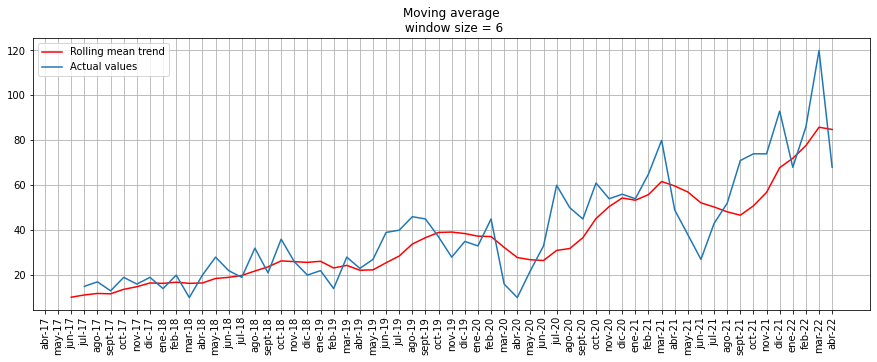

In [ ]:
plotMovingAverage(pddfTS['Venta_zona_2'], 6)

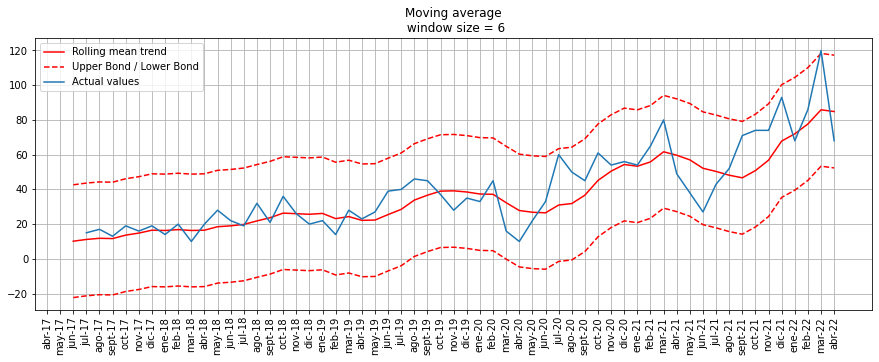

In [ ]:
plotMovingAverage(pddfTS['Venta_zona_2'], 6, plot_intervals=True, scale=1.96, plot_anomalies=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(X_train.Venta_zona_2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.231261
p-value: 0.660005


Dado que el valor p es mayor que el nivel de significancia (0,05), diferenciemos las series y veamos cómo se ve el gráfico de autocorrelación.

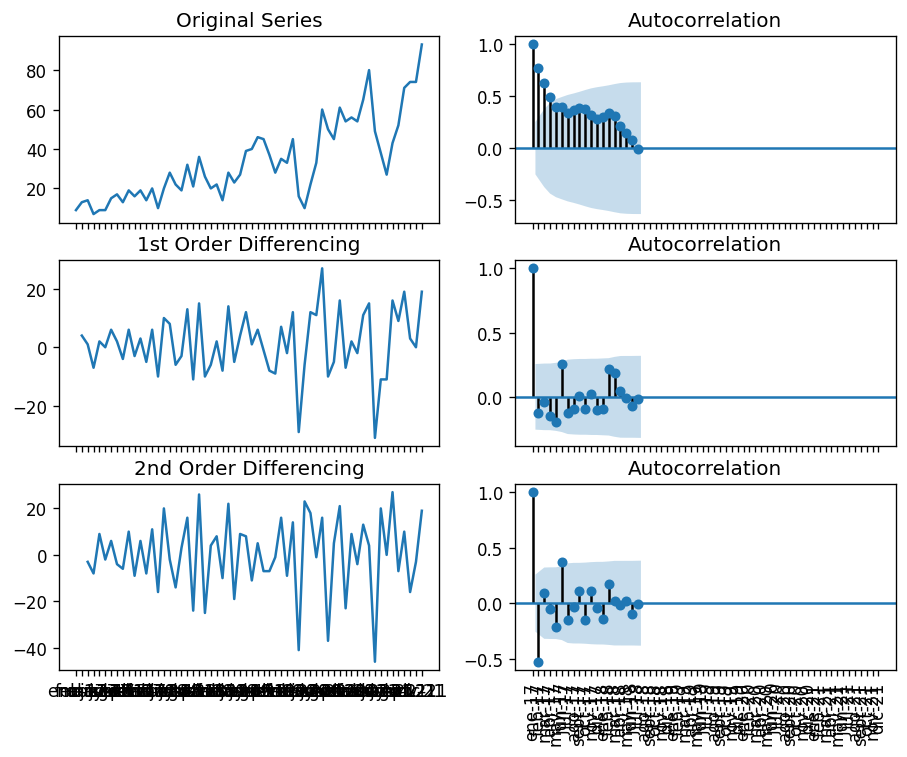

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train.Venta_zona_2); axes[0, 0].set_title('Original Series')
plot_acf(X_train.Venta_zona_2, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train.Venta_zona_2.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train.Venta_zona_2.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train.Venta_zona_2.diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

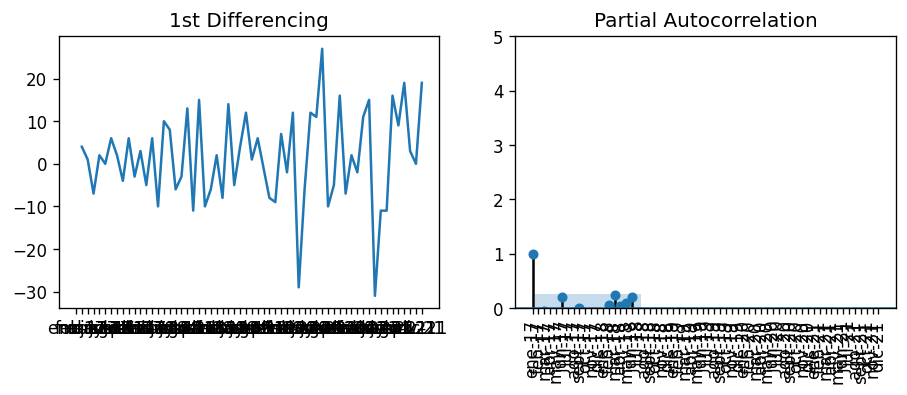

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train.Venta_zona_2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1])

plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

### MA (q) 

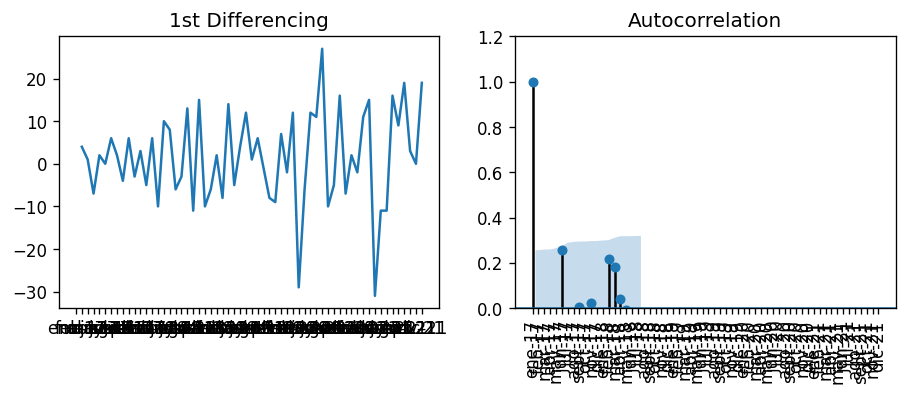

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train.Venta_zona_2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente la Y

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p,d,q)

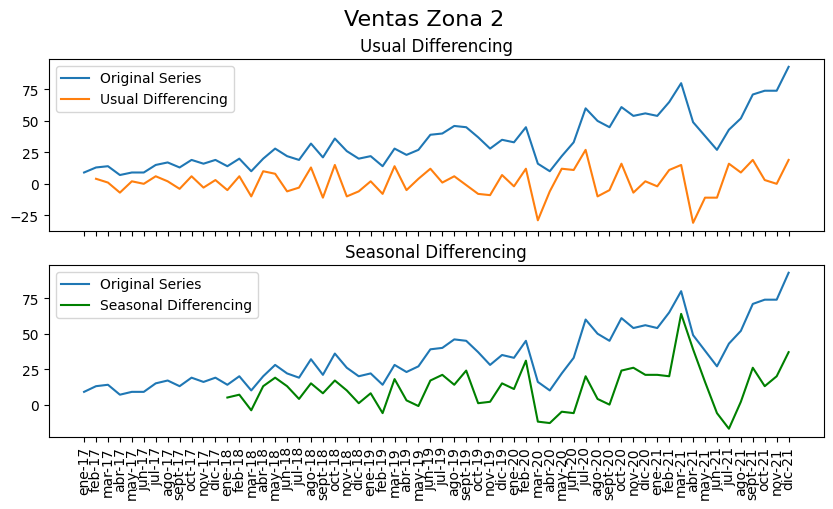

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train.Venta_zona_2, label='Original Series')
axes[0].plot(X_train.Venta_zona_2.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train.Venta_zona_2, label='Original Series')
axes[1].plot(X_train.Venta_zona_2.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 2', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(X_train.Venta_zona_2, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Venta_zona_2   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -219.383
Method:                       css-mle   S.D. of innovations              9.739
Date:                Wed, 22 Jun 2022   AIC                            446.765
Time:                        00:48:02   BIC                            455.076
Sample:                             1   HQIC                           450.009
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0277      0.172      5.961      0.000       0.690       1.366
ar.L1.D.Venta_zona_2     0.6036      0.119      5.075      0.000       0.370       0.837
ma.L1.D.Vent

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train.Venta_zona_2, order=(1,1,1), seasonal_order = (1,1,1,12))
model_fit = model.fit(disp=0)
print(model_fit.summary())

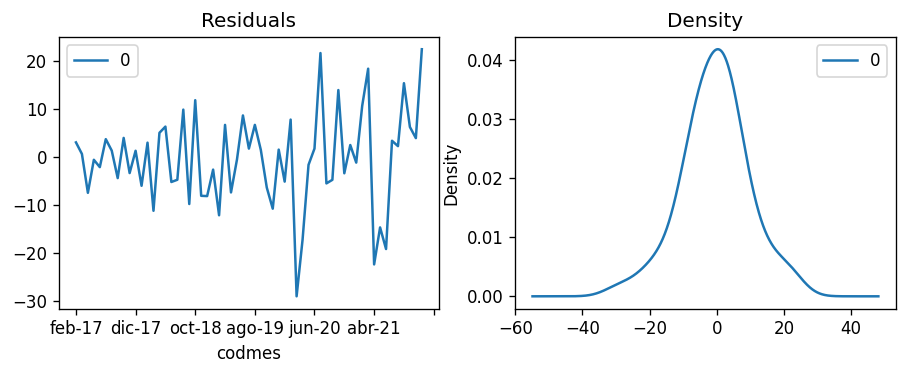

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

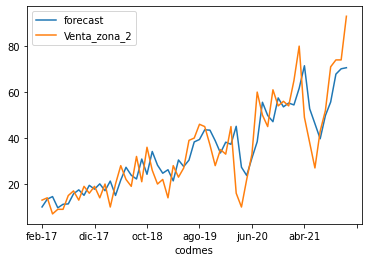

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

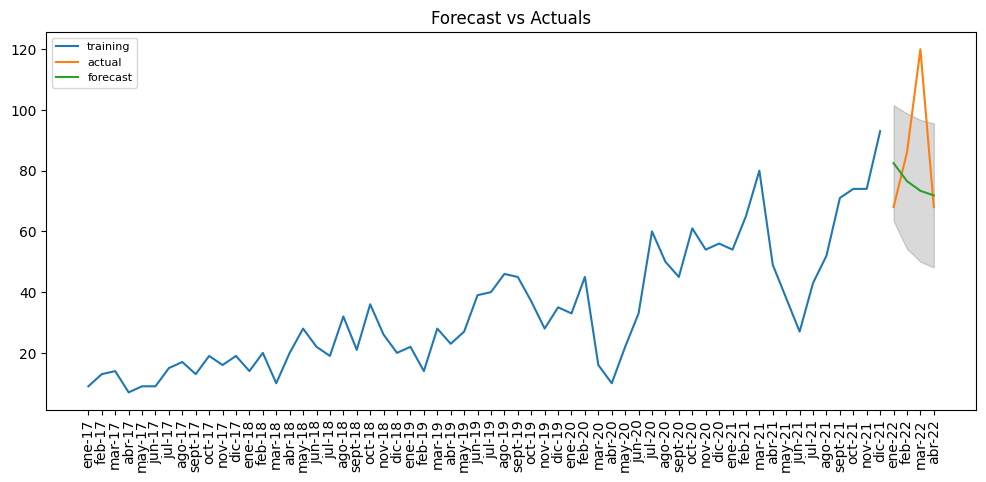

In [ ]:

# Forecast
fc, se, conf = model_fit.forecast(4, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=90)
plt.show()

In [ ]:
fc, se, conf  = model_fit.forecast(10, alpha=0.05)
fc

array([82.48422348, 76.54451208, 73.36681646, 71.85621493, 71.35183599,
       71.45479166, 71.9243216 , 72.615108  , 73.43944009, 74.34437752])

In [ ]:
model_res = model_fit.predict(start = 'feb-17' , end = 'dic-21', dynamic=False, typ = 'levels')

In [ ]:
pddfTS_res = pddfTS.copy()
pddfTS_res['venta_predicted'] = model_res

In [ ]:
fc, se, conf  = model_fit.forecast(4, alpha=0.05)

In [ ]:
pddfTS_res.iloc[-4:]['venta_predicted'] = fc

In [ ]:
pddfTS_res

,Venta_zona_2,venta_predicted
codmes,,
ene-17,9,NaN
feb-17,13,10.027665
mar-17,14,13.438516
abr-17,7,14.542365
may-17,9,9.654124
...,...,...
dic-21,93,70.607072
ene-22,68,82.484223
feb-22,86,76.544512


# Regresión

In [ ]:
pddfReg = pddfRes.copy()
pddfReg['venta_predicted'] = pddfTS_res[['venta_predicted']].iloc[8:].venta_predicted

In [ ]:
target = 'Venta_zona_2'

total_features = variables +\
                 [x + '_avg3' for x in variables] +\
                 [x + '_avg6' for x in variables] +\
                 [x + '_rat3to6' for x in variables] + ['venta_predicted']

In [ ]:
X_train_reg = pddfReg[:-4]
X_test_reg  = pddfReg[-4:]

In [ ]:
correlations = pd.DataFrame()
data = X_train_reg.copy()

for col in total_features:
  data_temp = data[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [ ]:
correlations.head(50)

,target,variable,correlacion,correlacion_abs
0,Venta_zona_2,venta_predicted,0.849793,0.849793
0,Venta_zona_2,ind_prec_12_distr,0.825511,0.825511
0,Venta_zona_2,ind_prec_alt,0.824984,0.824984
0,Venta_zona_2,ind_prec_12_distr_avg3,0.820910,0.820910
0,Venta_zona_2,ind_prec_alt_avg3,0.819387,0.819387
0,Venta_zona_2,ind_prec_med,0.809715,0.809715
0,Venta_zona_2,tip_camb_banc_venta_avg3,0.809472,0.809472
0,Venta_zona_2,ind_prec_cons_lima_met_alim_ener_avg6,0.807394,0.807394
0,Venta_zona_2,ind_prec_cons_lima_met_alim_ener,0.806367,0.806367
0,Venta_zona_2,ind_prec_med_avg3,0.805754,0.805754


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.precio_oferta_total_avg6)
plt.xlabel("venta pred", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

Text(0, 0.5, 'Venta_zona_2')

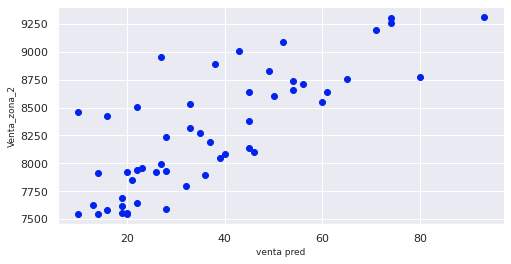

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.precio_oferta_total_avg6)
plt.xlabel("venta pred", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

Text(0, 0.5, 'Venta_zona_2')

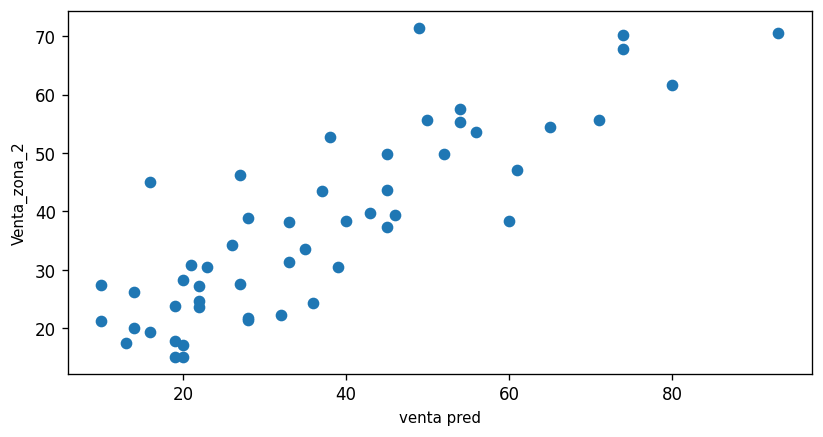

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.venta_predicted)
plt.xlabel("venta pred", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Tipo de cambio

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.tip_camb_banc_venta_avg3)
plt.xlabel("tip_camb_banc_venta_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Indice de precios de inmuebles 12 distritos de lima

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_12_distr_avg3)
plt.xlabel("ind_prec_12_distr_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Indice de precios al consumidor

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_cons_lima_met_alim_ener_avg3)
plt.xlabel("ind_prec_cons_lima_met_alim_ener_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Precio de inmuebles distritos altos

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_alt_avg3)
plt.xlabel("ind_prec_alt_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Tasa de interes

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.tasa_interes_act_avg6)
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Oferta en Zona 2

Text(0, 0.5, 'Venta_zona_2')

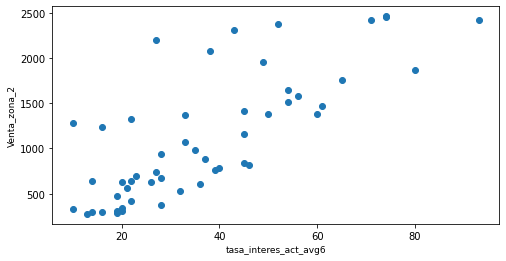

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.Oferta_zona_2_avg6)
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

Text(0, 0.5, 'Venta_zona_2')

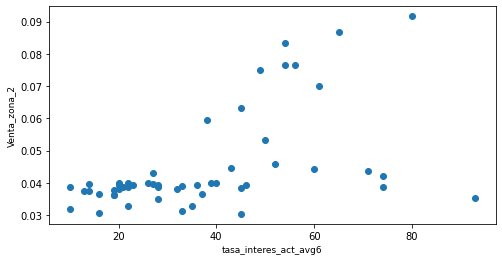

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.exp_PBI_avg3)
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)


In [ ]:
X_train_reg_f = pddfReg[:-4][['Venta_zona_2','Oferta_zona_2_avg6', 'exp_PBI_avg3', 'ind_tipo_camb_var_mes_avg3',
             'tasa_interes_act_avg6', 
             'ind_prec_alt_avg3', 
             'ind_prec_cons_lima_met_alim_ener_avg3',
             'ind_prec_12_distr_avg3',
             'tip_camb_banc_venta_avg3','precio_oferta_total_avg6','flg_feia_avg3',
             'venta_predicted']]

X_test_reg_f = pddfReg[['Venta_zona_2','Oferta_zona_2_avg6', 'exp_PBI_avg3', 'ind_tipo_camb_var_mes_avg3',
             'tasa_interes_act_avg6', 
             'ind_prec_alt_avg3', 
             'ind_prec_cons_lima_met_alim_ener_avg3',
             'ind_prec_12_distr_avg3',
             'tip_camb_banc_venta_avg3','precio_oferta_total_avg6','flg_feia_avg3',
             'venta_predicted']]  
                    

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reg_f)

X = scaler.transform(X_train_reg_f)
X_test = scaler.transform(X_test_reg_f)

#X_train_reg_f[[x + '_z' for x in X_train_reg_f.columns]] = 
#pd.DataFrame(X, columns = X_train_reg_f.columns).reset_index(drop=True)

In [ ]:
df = X_train_reg_f.copy().reset_index(drop = False)
df[[x + '_z' for x in X_train_reg_f.columns]] = pd.DataFrame(X)

df_test = X_test_reg_f.copy().reset_index(drop = False)
df_test[[x + '_z' for x in X_test_reg_f.columns]] = pd.DataFrame(X_test)

df.head(5)

,codmes,Venta_zona_2,Oferta_zona_2_avg6,exp_PBI_avg3,ind_tipo_camb_var_mes_avg3,tasa_interes_act_avg6,ind_prec_alt_avg3,ind_prec_cons_lima_met_alim_ener_avg3,ind_prec_12_distr_avg3,tip_camb_banc_venta_avg3,...,exp_PBI_avg3_z,ind_tipo_camb_var_mes_avg3_z,tasa_interes_act_avg6_z,ind_prec_alt_avg3_z,ind_prec_cons_lima_met_alim_ener_avg3_z,ind_prec_12_distr_avg3_z,tip_camb_banc_venta_avg3_z,precio_oferta_total_avg6_z,flg_feia_z,venta_predicted_z
0,sept-17,13,276.333333,0.037500,0.482319,17.083333,6371.636744,86.450159,6003.237702,3.264258,...,-0.492482,0.042539,1.775509,-0.550948,-0.938622,-0.745982,-0.795918,-1.213448,-0.636715,-1.277820
1,oct-17,19,284.666667,0.036167,0.184196,16.983333,6358.514340,86.111553,6004.982675,3.264823,...,-0.580199,-0.378635,1.715822,-0.579953,-1.071512,-0.742026,-0.793060,-1.244256,-0.636715,-1.428957
2,nov-17,16,294.500000,0.036500,-0.449227,16.950000,6345.391937,86.351134,6006.727649,3.254247,...,-0.558270,-1.273505,1.695926,-0.608958,-0.977485,-0.738070,-0.846513,-1.302103,-0.636715,-1.153903
3,dic-17,19,303.500000,0.036333,-0.250224,16.883333,6332.269533,86.700251,6008.472622,3.246954,...,-0.569235,-0.992362,1.656134,-0.637963,-0.840470,-0.734114,-0.883373,-1.349241,-0.636715,-1.258572
4,ene-18,14,302.166667,0.037333,0.217042,16.816667,6265.095563,86.682416,5949.140134,3.247615,...,-0.503447,-0.332231,1.616343,-0.786440,-0.847470,-0.868628,-0.880035,-1.369529,-0.636715,-1.112442


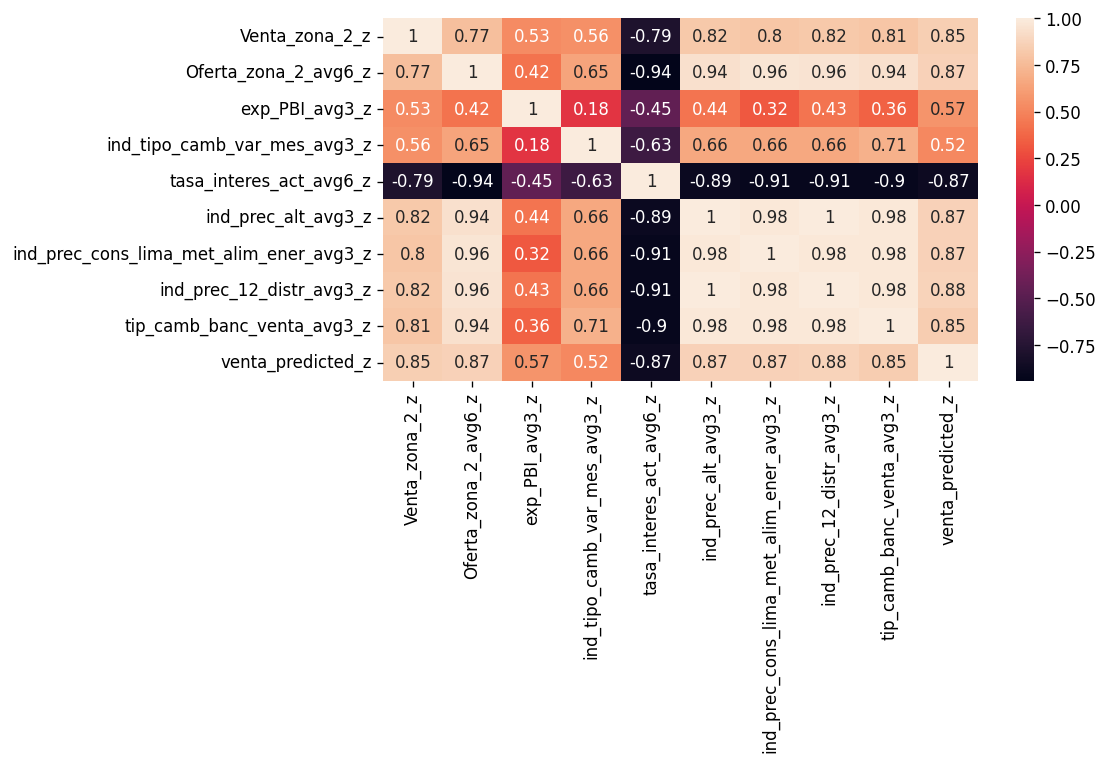

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
df['intercept_z'] = 1
df_test['intercept_z'] = 1


In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 
                                                                     'Oferta_zona_2_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     18.86
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           9.16e-12
Time:                        04:26:55   Log-Likelihood:                -34.629
No. Observations:                  52   AIC:                             87.26
Df Residuals:                      43   BIC:                             104.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 
                                                                     'Oferta_zona_2_avg6_z','ind_tipo_camb_var_mes_avg3_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     22.04
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           1.89e-12
Time:                        04:27:00   Log-Likelihood:                -34.647
No. Observations:                  52   AIC:                             85.29
Df Residuals:                      44   BIC:                             100.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 
                                                                     'Oferta_zona_2_avg6_z','ind_tipo_camb_var_mes_avg3_z',
                                                                     'tip_camb_banc_venta_avg3_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     25.99
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           4.25e-13
Time:                        04:27:04   Log-Likelihood:                -34.881
No. Observations:                  52   AIC:                             83.76
Df Residuals:                      45   BIC:                             97.42
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 
                                                                     'Oferta_zona_2_avg6_z','ind_tipo_camb_var_mes_avg3_z',
                                                                     'tip_camb_banc_venta_avg3_z','tasa_interes_act_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     31.73
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           7.69e-14
Time:                        04:27:07   Log-Likelihood:                -34.976
No. Observations:                  52   AIC:                             81.95
Df Residuals:                      46   BIC:                             93.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 'ind_prec_alt_avg3_z',
                                                                     'Oferta_zona_2_avg6_z','ind_tipo_camb_var_mes_avg3_z',
                                                                     'tip_camb_banc_venta_avg3_z','tasa_interes_act_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     40.36
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           1.21e-14
Time:                        04:27:10   Log-Likelihood:                -35.059
No. Observations:                  52   AIC:                             80.12
Df Residuals:                      47   BIC:                             89.87
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df[[x for x in df.columns.tolist() if '_z' in x[-2:]]].drop(columns=['Venta_zona_2_z', 'ind_prec_alt_avg3_z',
                                                                     'Oferta_zona_2_avg6_z','ind_tipo_camb_var_mes_avg3_z','precio_oferta_total_avg6_z',
                                                                     'tip_camb_banc_venta_avg3_z','tasa_interes_act_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     46.57
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           2.98e-14
Time:                        05:05:49   Log-Likelihood:                -38.330
No. Observations:                  52   AIC:                             84.66
Df Residuals:                      48   BIC:                             92.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
df['macro_pred'] = 0.2716*df.exp_PBI_avg3_z + 0.6674*df.ind_prec_cons_lima_met_alim_ener_avg3_z + 0.1932*df.flg_feia_avg3_z + 5.648e-15
df_test['macro_pred'] = 0.2716*df_test.exp_PBI_avg3_z + 0.6674*df_test.ind_prec_cons_lima_met_alim_ener_avg3_z + 0.1932*df_test.flg_feia_avg3_z + 5.648e-15



In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df[['macro_pred', 'venta_predicted_z', 'intercept_z']])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     83.84
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           1.52e-16
Time:                        04:28:54   Log-Likelihood:                -35.134
No. Observations:                  52   AIC:                             76.27
Df Residuals:                      49   BIC:                             82.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
macro_pred            0.7258      0.21

In [ ]:
df['venta_predicted_final_z'] = 0.2570*df.venta_predicted_z + 0.7258*df.macro_pred + 1.665e-16
df_test['venta_predicted_final_z'] = 0.2570*df_test.venta_predicted_z + 0.7258*df_test.macro_pred + 1.665e-16


In [ ]:
df[['venta_predicted_final_z', 'Venta_zona_2_z']].corr()

,venta_predicted_final_z,Venta_zona_2_z
venta_predicted_final_z,1.000000,0.879688
Venta_zona_2_z,0.879688,1.000000


In [ ]:
df[['venta_predicted_z', 'Venta_zona_2_z']].corr()**2

,venta_predicted_z,Venta_zona_2_z
venta_predicted_z,1.000000,0.722148
Venta_zona_2_z,0.722148,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


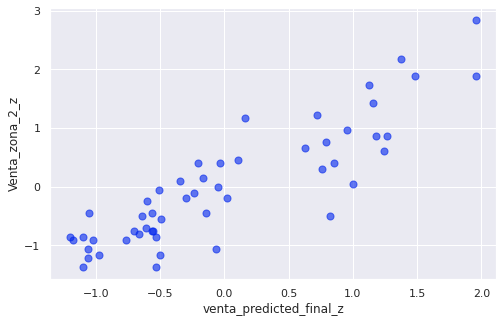

In [ ]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_palette('winter')

df.plot(kind="scatter", x="venta_predicted_final_z", y="Venta_zona_2_z", alpha=0.6, s=50)

In [ ]:
df.head()

,codmes,Venta_zona_2,Oferta_zona_2_avg6,exp_PBI_avg3,ind_tipo_camb_var_mes_avg3,tasa_interes_act_avg6,ind_prec_alt_avg3,ind_prec_cons_lima_met_alim_ener_avg3,ind_prec_12_distr_avg3,tip_camb_banc_venta_avg3,...,exp_PBI_avg3_z,ind_tipo_camb_var_mes_avg3_z,tasa_interes_act_avg6_z,ind_prec_alt_avg3_z,ind_prec_cons_lima_met_alim_ener_avg3_z,ind_prec_12_distr_avg3_z,tip_camb_banc_venta_avg3_z,venta_predicted_z,macro_pred,venta_predicted_final_z
0,sept-17,13,276.333333,0.037500,0.482319,17.083333,6371.636744,86.450159,6003.237702,3.264258,...,-0.492482,0.042539,1.775509,-0.550948,-0.938622,-0.745982,-0.795918,-1.277820,-0.814779,-0.977430
1,oct-17,19,284.666667,0.036167,0.184196,16.983333,6358.514340,86.111553,6004.982675,3.264823,...,-0.580199,-0.378635,1.715822,-0.579953,-1.071512,-0.742026,-0.793060,-1.428957,-0.935645,-1.106773
2,nov-17,16,294.500000,0.036500,-0.449227,16.950000,6345.391937,86.351134,6006.727649,3.254247,...,-0.558270,-1.273505,1.695926,-0.608958,-0.977485,-0.738070,-0.846513,-1.153903,-0.862415,-0.953656
3,dic-17,19,303.500000,0.036333,-0.250224,16.883333,6332.269533,86.700251,6008.472622,3.246954,...,-0.569235,-0.992362,1.656134,-0.637963,-0.840470,-0.734114,-0.883373,-1.258572,-0.768848,-0.943835
4,ene-18,14,302.166667,0.037333,0.217042,16.816667,6265.095563,86.682416,5949.140134,3.247615,...,-0.503447,-0.332231,1.616343,-0.786440,-0.847470,-0.868628,-0.880035,-1.112442,-0.753656,-0.875783


In [ ]:
mod = sm.OLS(df.Venta_zona_2, df[['venta_predicted_final_z', 'intercept_z']])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Venta_zona_2   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     171.1
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           9.19e-18
Time:                        04:29:58   Log-Likelihood:                -190.07
No. Observations:                  52   AIC:                             384.1
Df Residuals:                      50   BIC:                             388.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
venta_predicted_final_z   

In [ ]:
df['venta_predicted_escalado'] = 19.6760*df.venta_predicted_final_z + 37.0000
df_test['venta_predicted_escalado'] = 19.6760*df_test.venta_predicted_final_z + 37.0000


In [ ]:
df_test[['codmes','venta_predicted_escalado', 'Venta_zona_2']].to_csv('results_zona2.csv', index=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


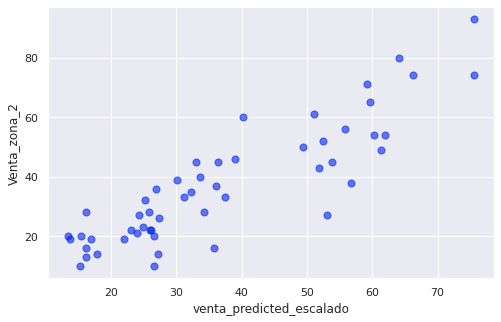

In [ ]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_palette('winter')

df.plot(kind="scatter", x="venta_predicted_escalado", y="Venta_zona_2", alpha=0.6, s=50)

In [ ]:
df[['venta_predicted_escalado', 'Venta_zona_2']].corr()**2

,venta_predicted_escalado,Venta_zona_2
venta_predicted_escalado,1.00000,0.77385
Venta_zona_2,0.77385,1.00000
